In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from sklearn.model_selection import train_test_split

#configure jax as nn backend
import os
os.environ["KERAS_BACKEND"] = "jax"

import keras
from keras import layers

In [61]:
os.chdir(r"C:\Users\toddm\.kaggle\playground-series-s4e10")
test_submission_data = pd.read_csv("test.csv")
training_data = pd.read_csv("train.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [62]:
train_data, test_data = train_test_split(training_data, test_size=0.2, random_state=42)

def split_features_labels(df):
    feature_df = df.drop(columns=['loan_status'])
    labels = df[['id', 'loan_status']]
    return feature_df, labels

train_data, train_labels = split_features_labels(train_data)
test_data, test_labels = split_features_labels(test_data)


In [7]:
train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
14337,14337,36,50000,RENT,0.0,HOMEIMPROVEMENT,C,7200,13.85,0.14,Y,15
17117,17117,27,43200,RENT,3.0,DEBTCONSOLIDATION,C,5000,11.66,0.12,Y,9
32590,32590,25,70000,MORTGAGE,0.0,EDUCATION,A,8000,7.88,0.11,N,3
55811,55811,39,75000,MORTGAGE,2.0,DEBTCONSOLIDATION,A,15000,6.54,0.20,N,11
40120,40120,22,45600,RENT,5.0,MEDICAL,A,4000,7.66,0.09,N,2


In [8]:
train_labels

,id,loan_status
14337,14337,0
17117,17117,0
32590,32590,0
55811,55811,0
40120,40120,0
...,...,...
54343,54343,0
38158,38158,0
860,860,0
15795,15795,0


In [9]:
print(train_data.shape)
print(test_data.shape)

(46916, 12)
(11729, 12)


In [10]:
print(test_data.isnull().sum())

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [53]:
cat_features = ["person_home_ownership", "loan_intent", "loan_grade", 
                "cb_person_default_on_file"]
num_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

train_mean = train_data[num_features].mean()
train_std = train_data[num_features].std()

# Scale the numberical values
def encode_and_scale(df, df_mean=train_mean, df_std=train_std):
    result_df = pd.get_dummies(df[cat_features])
    result_df[num_features] = (df[num_features]-df_mean[num_features])/df_std[num_features]
    return result_df

train_data_processed = encode_and_scale(train_data)
test_data_processed = encode_and_scale(test_data)
test_submission_data_processed = encode_and_scale(test_submission_data)

In [63]:
train_data_processed

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,...,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
14337,False,False,False,True,False,False,True,False,False,False,...,False,False,True,1.397810,-0.366411,-1.182667,-0.359699,1.042706,-0.205760,2.274628
17117,False,False,False,True,True,False,False,False,False,False,...,False,False,True,-0.091850,-0.542746,-0.429368,-0.755227,0.321832,-0.424082,0.787961
32590,True,False,False,False,False,True,False,False,False,False,...,False,True,False,-0.422886,0.152223,-1.182667,-0.215871,-0.922416,-0.533243,-0.698707
55811,True,False,False,False,True,False,False,False,False,False,...,False,True,False,1.894363,0.281882,-0.680468,1.042627,-1.363498,0.449206,1.283517
40120,False,False,False,True,False,False,False,True,False,False,...,False,True,False,-0.919439,-0.480510,0.072832,-0.935012,-0.994832,-0.751565,-0.946485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,False,False,False,True,True,False,False,False,False,False,...,False,True,False,2.887470,-0.107094,-0.931568,1.042627,-0.099500,0.995011,2.522406
38158,True,False,False,False,False,False,False,True,False,False,...,False,True,False,-0.919439,0.152223,-0.931568,0.143700,-1.337165,-0.205760,-0.698707
860,True,False,False,False,False,False,False,False,True,False,...,False,True,False,0.735739,0.670857,-1.182667,-1.051873,-1.732164,-1.406530,0.044627
15795,True,False,False,False,False,True,False,False,False,False,...,False,False,True,-0.091850,1.189491,-0.680468,-1.114798,0.838623,-1.406530,0.787961


In [88]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

x_data = train_data_processed
y_data = train_labels['loan_status']

history = model.fit(x_data, 
                    y_data,
                    epochs=20,
                    batch_size=512,
                    validation_split=0.2)



Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8293 - loss: 0.4742 - val_accuracy: 0.8940 - val_loss: 0.2718
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9053 - loss: 0.2522 - val_accuracy: 0.9200 - val_loss: 0.2359
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9193 - loss: 0.2279 - val_accuracy: 0.9248 - val_loss: 0.2218
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9281 - loss: 0.2149 - val_accuracy: 0.9304 - val_loss: 0.2126
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9341 - loss: 0.2001 - val_accuracy: 0.9338 - val_loss: 0.2058
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9376 - loss: 0.1973 - val_accuracy: 0.9365 - val_loss: 0.2018
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9381 - loss: 0.1961 - val_accuracy: 0.9370 - val_loss: 0.2001
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9402 - loss: 0.1897 - val_accuracy: 0.9389 - val_loss:

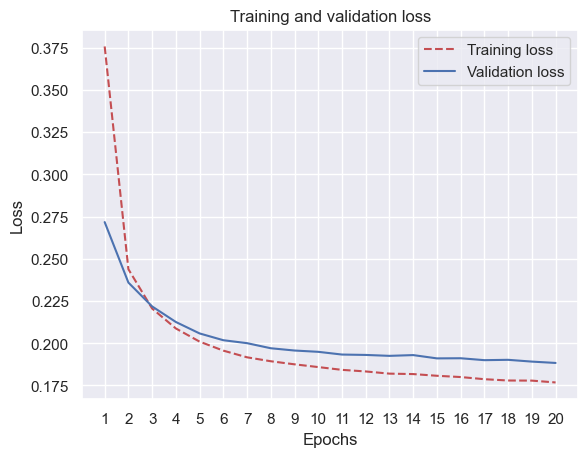

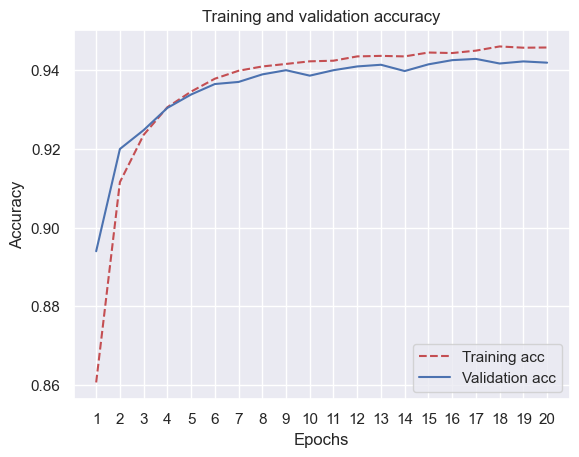

In [90]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r--", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.savefig("imdb_loss_plot.png", dpi=300)
plt.show()

plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("imdb_accuracy_plot.png", dpi=300)
plt.show()

In [92]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

x_test = test_data_processed
y_test = test_labels['loan_status']

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.fit(x_test, y_test, epochs=15, batch_size=512)

results = model.evaluate(x_test, y_test)
results

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7080 - loss: 0.5980
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8634 - loss: 0.3680
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8823 - loss: 0.2989
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9013 - loss: 0.2559
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9058 - loss: 0.2457
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9120 - loss: 0.2291
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9154 - loss: 0.2225
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9175 - loss: 0.2173
Epoch 9/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9196 - loss: 0.2137
Epoch 10/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9210 - loss: 0.2145   
Epoch 11/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9263 - loss: 0.2042
Epoch 12/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9253 -

[0.18829448521137238, 0.9369085431098938]

In [93]:
prediction = model.predict(test_submission_data_processed)


1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step


In [71]:
submission = pd.DataFrame(prediction,columns=['loan_status'])
submission.insert(0, 'id', test_submission_data['id'])
submission

,id,loan_status
0,58645,0.996492
1,58646,0.017913
2,58647,0.543929
3,58648,0.026530
4,58649,0.052918
...,...,...
39093,97738,0.041810
39094,97739,0.006300
39095,97740,0.020512
39096,97741,0.246271


In [78]:
assert(submission.shape == sample_submission.shape)
submission.to_csv("loan_submission.csv",index=False)